# Ambient profile

In this tutorial, we'll be walking through the steps to calculating the ambient profile.   

In the first experiment, an equal number of human HEK293T cells and mouse NIH3T3 cells were pooled and sequenced, transcripts from the other organism were unambiguously ambient contamination. The original dataset is downloaded from 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/20-k-1-1-mixture-of-human-hek-293-t-and-mouse-nih-3-t-3-cells-3-ht-v-3-1-3-1-high-6-1-0), and cell annotation file is available at  [scAR-reproducibility/data](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data). We will be using two approaches to calculate the ambient profile.  

In the second experiment, Gene Expression, Feature Barcode, BCR Enriched, and TCR Enriched libraries were generated from 16,520 human peripheral blood mononuclear cells (PBMCs) of a healthy male donor. We will be using the Feature Barcode data to demonstrate the calculation of ambient profile. For details, see 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/human-pbmc-from-a-healthy-donor-10-k-cells-v-2-2-standard-5-0-0).

<div class="alert alert-info">

Note

To run this notebook on your device, you need to install [![scAR](https://img.shields.io/badge/install-scar-brightgreen)](https://scar-tutorials.readthedocs.io/en/latest/Installation.html). 

Alternatively, you can also run this notebook on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Novartis/scAR/blob/main/docs/tutorials/scAR_tutorial_ambient_profile.ipynb)

</div>

In [ ]:
# Run this cell to install scar in Colab
# Skip this cell if running on your own device

%pip install scanpy
%pip install git+https://github.com/Novartis/scAR.git
%pip install matplotlib==3.1.3  # Specify this matplotlib version to avoid errors

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

import warnings
warnings.simplefilter("ignore")

## mRNA ambient profile
### Download data

The raw and filtered count matrices can be downloaded from 10x Dataset.

#### The raw data

cellranger output: raw_feature_bc_matrix

In [2]:
hgmm_20k_raw = sc.read_10x_h5(filename='20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5ad',
                                 backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_hgmm_3p_HT_nextgem_Chromium_X/20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5');
hgmm_20k_raw.var_names_make_unique();

#### The filtered data

cellranger output: filtered_feature_bc_matrix

In [3]:
hgmm_20k = sc.read_10x_h5(filename='20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5ad',
                             backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_hgmm_3p_HT_nextgem_Chromium_X/20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5');
hgmm_20k.var_names_make_unique();

Gene and cell filtering. Filter out genes of low coverage to save memory.

In [4]:
sc.pp.filter_genes(hgmm_20k, min_counts=200);
sc.pp.filter_genes(hgmm_20k, max_counts=6000);
sc.pp.filter_cells(hgmm_20k, min_genes=200);

In [5]:
hgmm_20k

AnnData object with n_obs × n_vars = 16292 × 16586
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

### Estimate the ambient profile

#### Option1, Calculate the ambient profile using the `setup_anndata` method

<div class="alert alert-info">

Steps:

`setup_anndata` is inspired by [EmptyDrops Lun2019](https://doi.org/10.1186/s13059-019-1662-y), which assumes that cell-free droplets are sampled from a multinomial distribution.

1) It first calculates an initial ambient profile by averaging all droplets in raw_adata  
2) It tested whether droplets fit the multinomial distribution (the ambient profile as the prob parameter). The relatively high probabilities suggest cell-free droplets  
3) It re-calculates the ambient profile using the identified cell-free droplets  
4) It repeats step 2 and step 3 for `iterations`
5) The final ambient profile is saved in `adata.uns`

</div>

2023-05-01 19:03:05|INFO|setup_anndata|Randomly sample 199666 droplets from 199666 droplets.
2023-05-01 19:03:05|INFO|setup_anndata|Estimating ambient profile for ['Gene Expression']...
2023-05-01 19:03:30|INFO|setup_anndata|Iteration: 1
2023-05-01 19:03:54|INFO|setup_anndata|Iteration: 2
2023-05-01 19:04:19|INFO|setup_anndata|Iteration: 3
2023-05-01 19:04:19|INFO|setup_anndata|Estimated ambient profile for Gene Expression saved in adata.uns
2023-05-01 19:04:19|INFO|setup_anndata|Estimated ambient profile for all features saved in adata.uns


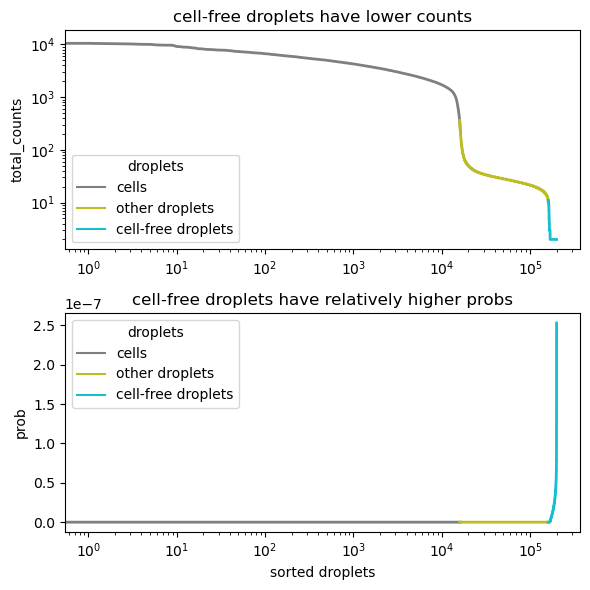

In [6]:
from scar import setup_anndata

setup_anndata(
    adata = hgmm_20k,
    raw_adata = hgmm_20k_raw,
    prob = 0.995,
    kneeplot = True
)

In [7]:
ambient_profile0 = hgmm_20k.uns["ambient_profile_Gene Expression"]
ambient_profile0.head()

,ambient_profile_Gene Expression
GRCh38_AL627309.5,0.000000
GRCh38_LINC01128,0.000127
GRCh38_LINC00115,0.000000
GRCh38_FAM41C,0.000010
GRCh38_AL645608.2,0.000010


#### Option2, Calculate the ambient profile using a kneeplot

<div class="alert alert-info">

Steps:

This option is based on total counts of droplets.

1) It first plots a kneeplot
2) It identifies subpopulations of droplets with arbitrary thresholds  
3) It calculates the ambient profile from the subpopulation of 'cell-free droplets'

</div>

In [8]:
all_droplets = pd.DataFrame(hgmm_20k_raw.X.sum(axis=1), index = hgmm_20k_raw.obs_names, columns=['total_counts'])

all_droplets['droplets'] = 'cell-free droplets'
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>12, 'droplet II')
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>40, 'droplet I')
all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets.index.isin(hgmm_20k.obs_names), 'cells')
all_droplets = all_droplets.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
all_droplets = all_droplets.loc[all_droplets['total_counts']>0]
all_droplets = all_droplets.set_index('index').rename_axis('cells')

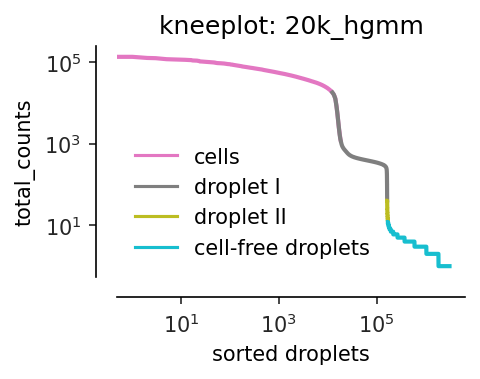

In [9]:
plt.figure(figsize=(3, 2), dpi=150)

ax = sns.lineplot(data = all_droplets,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'droplet I', 'droplet II', 'cell-free droplets'],
                  palette=sns.color_palette()[-4:],
                  markers=False,
                  lw=2,
                  ci=None)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: 20k_hgmm')

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

In [10]:
cell_free = hgmm_20k_raw[hgmm_20k_raw.obs_names.isin(all_droplets[all_droplets['droplets']=='cell-free droplets'].index)]

cell_free = cell_free[:, hgmm_20k.var_names]

# average and normalize the transcript in cell-free droplets.
ambient_profile1 = pd.DataFrame((cell_free.X.sum(axis=0)/cell_free.X.sum()).A1, index = hgmm_20k.var_names, columns = ['ambient profile'])

ambient_profile1.head()

,ambient profile
GRCh38_AL627309.5,0.000006
GRCh38_LINC01128,0.000086
GRCh38_LINC00115,0.000015
GRCh38_FAM41C,0.000017
GRCh38_AL645608.2,0.000015


Check that these two approaches generate consistent results

In [11]:
from sklearn.metrics import r2_score

r2_score(ambient_profile0, ambient_profile1)

0.7826796002453497

## The ambient profile of feature barcodes

### Download data

The raw and filtered count matrices can be downloaded from 10x Dataset.

#### The raw data

cellranger output: raw_feature_bc_matrix

In [12]:
PBMC_raw = sc.read_10x_h5(filename='sc5p_v2_hs_PBMC_10k_f_raw_feature_bc_matrix.h5ad',
                          gex_only=False,
                          backup_url='https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_f_raw_feature_bc_matrix.h5');
PBMC_raw.var_names_make_unique();

  0%|          | 0.00/6.19M [00:00<?, ?B/s]

#### The filtered data

cellranger output: filtered_feature_bc_matrix

In [13]:
PBMC_filtered = sc.read_10x_h5(filename='sc5p_v2_hs_PBMC_10k_f_filtered_feature_bc_matrix.h5ad',
                          gex_only=False,
                          backup_url='https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_f_filtered_feature_bc_matrix.h5');
PBMC_filtered.var_names_make_unique();

  0%|          | 0.00/351k [00:00<?, ?B/s]

In [14]:
PBMC_filtered

AnnData object with n_obs × n_vars = 12773 × 19
    var: 'gene_ids', 'feature_types', 'genome'

In [15]:
PBMC_raw

AnnData object with n_obs × n_vars = 737280 × 19
    var: 'gene_ids', 'feature_types', 'genome'

### Estimate the ambient profile

2023-05-01 19:04:39|INFO|setup_anndata|Randomly sample 515704 droplets from 515704 droplets.
2023-05-01 19:04:39|INFO|setup_anndata|Estimating ambient profile for ['Antibody Capture']...
2023-05-01 19:04:40|INFO|setup_anndata|Iteration: 1
2023-05-01 19:04:41|INFO|setup_anndata|Iteration: 2
2023-05-01 19:04:41|INFO|setup_anndata|Iteration: 3
2023-05-01 19:04:41|INFO|setup_anndata|Estimated ambient profile for Antibody Capture saved in adata.uns
2023-05-01 19:04:41|INFO|setup_anndata|Estimated ambient profile for all features saved in adata.uns


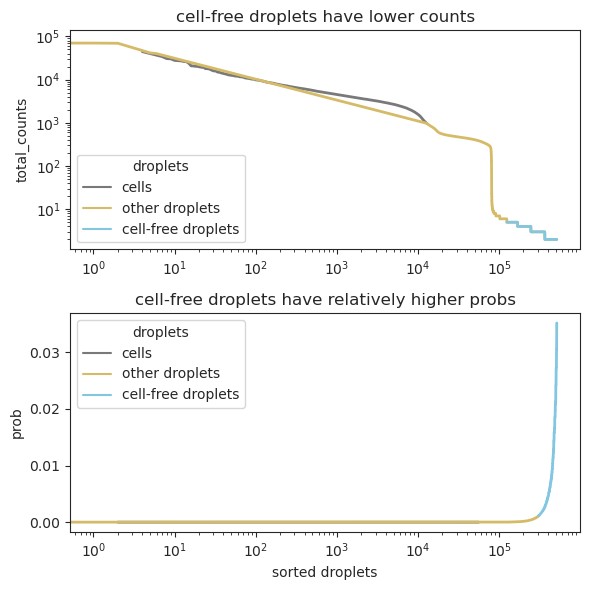

In [16]:
from scar import setup_anndata

setup_anndata(
    adata = PBMC_filtered,
    raw_adata = PBMC_raw,
    prob = 0.7, # try a lower prob value when error ocurs
    min_raw_counts=2,
    kneeplot = True
)

In [17]:
PBMC_filtered.uns["ambient_profile_Antibody Capture"]

,ambient_profile_Antibody Capture
CD3_TotalC,0.074758
CD19_TotalC,0.029752
CD45RA_TotalC,0.140524
CD4_TotalC,0.126031
CD8a_TotalC,0.066558
CD14_TotalC,0.037047
CD16_TotalC,0.007975
CD56_TotalC,0.013442
CD25_TotalC,0.089229
CD45RO_TotalC,0.026414
